In [1]:
!pip install imblearn

# **Preprocessing**

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Read the original dataset
data = pd.read_csv("hwc.csv")
print("Original Data Class Distribution:")
print(data['P_HABITABLE'].value_counts())

# Check if 'P_HABITABLE' exists
if 'P_HABITABLE' not in data.columns:
    print("'P_HABITABLE' column not found. Adding it with default values.")
    data['P_HABITABLE'] = 0  # Default to non-habitable if missing
else:
    print("'P_HABITABLE' column found.")
    # Check the data type of 'P_HABITABLE'
    if data['P_HABITABLE'].dtype == 'object':
        print("'P_HABITABLE' is of type object. Attempting to convert to numeric.")
        # Convert to numeric, coercing errors to NaN
        data['P_HABITABLE'] = pd.to_numeric(data['P_HABITABLE'], errors='coerce')
        # Check for any conversion issues
        if data['P_HABITABLE'].isnull().any():
            print("Some 'P_HABITABLE' entries could not be converted to numeric. Filling with mode.")
            mode_value = data['P_HABITABLE'].mode()[0]
            data['P_HABITABLE'] = data['P_HABITABLE'].fillna(mode_value)
        print("Conversion complete. Class distribution:")
        print(data['P_HABITABLE'].value_counts())
    else:
        print("'P_HABITABLE' is already numeric.")
        print("Class distribution:")
        print(data['P_HABITABLE'].value_counts())

# Select numeric columns, ensuring 'P_HABITABLE' is included
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Ensure 'P_HABITABLE' is included in numeric columns
if 'P_HABITABLE' not in numeric_cols:
    numeric_cols.append('P_HABITABLE')

# Select only numeric columns
data = data[numeric_cols]

# Handle missing 'P_RADIUS' and 'P_MASS' columns as before
if 'P_RADIUS' not in data.columns or 'P_MASS' not in data.columns:
    print("Columns 'P_RADIUS' or 'P_MASS' not found. Skipping calculations related to them.")
else:
    print("Handling missing 'P_RADIUS' and 'P_MASS' values.")
    # Calculate planet radius/mass if missing
    for i, row in data.iterrows():
        if pd.isna(row['P_RADIUS']) and not pd.isna(row['P_MASS']):
            if row['P_MASS'] < 2.04:
                c, s = 0.00346, 0.2790
            elif row['P_MASS'] < 132:
                c, s = -0.0925, 0.589
            elif row['P_MASS'] < 26600:
                c, s = 1.25, -0.044
            else:
                c, s = -2.85, 0.881
            data.loc[i, 'P_RADIUS'] = c + row['P_MASS'] * s
        elif pd.isna(row['P_MASS']) and not pd.isna(row['P_RADIUS']):
            if row['P_RADIUS'] < 1.23:
                c, s = 0.00346, 0.2790
            elif row['P_RADIUS'] < 11.1:
                c, s = -0.0925, 0.589
            else:
                c, s = -2.85, 0.881
            data.loc[i, 'P_MASS'] = (row['P_RADIUS'] - c) / s

# Impute missing values instead of dropping rows
print("\nChecking for missing values before imputation:")
print(data.isnull().sum())

# Define an imputer (you can choose different strategies like 'mean', 'median', 'most_frequent')
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

print("\nData after imputation:")
print(data_imputed.head())

print("\nClass distribution after imputation:")
print(data_imputed['P_HABITABLE'].value_counts())

# Separate features and target column
features = data_imputed.drop(columns=['P_HABITABLE'])
target = data_imputed['P_HABITABLE']

# Ensure 'P_HABITABLE' is not included in features
assert 'P_HABITABLE' not in features.columns, "'P_HABITABLE' is still in features!"

# Normalize only the feature columns using z-score
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
normalized_df = pd.DataFrame(normalized_features, columns=features.columns)

# Add the target column back without normalization
normalized_df['P_HABITABLE'] = target.values
print("\nNormalized Data Class Distribution:")
print(normalized_df['P_HABITABLE'].value_counts())

# Export to Excel
normalized_df.to_excel("hwc.xlsx", index=False)
print("\nNormalized data saved to 'hwc.xlsx'.")

Original Data Class Distribution:
P_HABITABLE
0.0    3411
2.0      30
1.0      17
Name: count, dtype: int64
'P_HABITABLE' column found.
'P_HABITABLE' is already numeric.
Class distribution:
P_HABITABLE
0.0    3411
2.0      30
1.0      17
Name: count, dtype: int64
Handling missing 'P_RADIUS' and 'P_MASS' values.

Checking for missing values before imputation:
P_YEAR                 0
P_MASS                 3
P_MASS_ERROR_MIN    1794
P_MASS_ERROR_MAX    1794
P_MASS_LIMIT           0
                    ... 
S_TIDAL_LOCK           2
P_HABZONE_OPT          1
P_HABZONE_CON          1
P_HABITABLE            1
P_ESI                 95
Length: 99, dtype: int64

Data after imputation:
   P_YEAR  P_MASS  P_MASS_ERROR_MIN  P_MASS_ERROR_MAX  P_MASS_LIMIT  P_RADIUS  \
0  2020.0  250.00       -120.000000        413.000000           0.0     13.90   
1  2013.0   16.60         -3.600000          4.400000           0.0      2.90   
2  2016.0    5.10       -110.900604        147.317762           0.0     

# **Model Building**

In [5]:
# !pip install imblearn
!pip install openpyxl

In [8]:
"""Customized Model Building Script for Multi-Class Classification"""

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, classification_report

# Read the processed dataset
hwc_data = pd.read_excel("hwc.xlsx")
print("Initial Data:")
print(hwc_data.head())
print("\nClass distribution in the entire dataset:")
print(hwc_data['P_HABITABLE'].value_counts())

# Drop classes with fewer than 2 samples (required for stratify to work)
class_counts = hwc_data['P_HABITABLE'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
hwc_data = hwc_data[hwc_data['P_HABITABLE'].isin(valid_classes)]

print("\nFiltered Class Distribution (after dropping rare classes):")
print(hwc_data['P_HABITABLE'].value_counts())

# Define model builders for multi-class classification
def svc_model_builder(X_train, y_train, X_test):
    svc = SVC(random_state=12, probability=True, decision_function_shape='ovr')
    param_grid = {
        'C': [1, 10, 100, 1000],
        'gamma': [0.001, 0.0001],
        'kernel': ['sigmoid', 'rbf']
    }
    clf = GridSearchCV(svc, param_grid, cv=5, scoring='f1_macro', return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    return y_pred, y_proba

def mlpc_model_builder(X_train, y_train, X_test):
    n_features = X_train.shape[1]
    hidden_layers = [i for i in range(n_features - 2, 1, -2)]
    if not hidden_layers:
        hidden_layers = [2]
    mlpc = MLPClassifier(hidden_layer_sizes=tuple(hidden_layers), early_stopping=True,
                         random_state=12, max_iter=10000)
    param_grid = {
        'solver': ['lbfgs', 'adam', 'sgd'],
        'hidden_layer_sizes': [tuple(hidden_layers), (50,), (100,)]
    }
    clf = GridSearchCV(mlpc, param_grid, cv=5, scoring='f1_macro', return_train_score=False, n_jobs=-1)
    clf.fit(X_train.values, y_train)
    y_pred = clf.predict(X_test.values)
    if hasattr(clf.best_estimator_, "predict_proba"):
        y_proba = clf.predict_proba(X_test.values)
    elif hasattr(clf.best_estimator_, "decision_function"):
        y_proba = clf.decision_function(X_test.values)
    else:
        y_proba = y_pred  # Fallback
    return y_pred, y_proba

def knn_model_builder(X_train, y_train, X_test):
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': range(1, 11)}
    clf = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro', return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf.best_estimator_, "predict_proba"):
        y_proba = clf.predict_proba(X_test)
    else:
        y_proba = clf.predict(X_test)  # Fallback
    return y_pred, y_proba

def lr_model_builder(X_train, y_train, X_test):
    logreg = LogisticRegression(random_state=12, max_iter=10000, solver='lbfgs', class_weight='balanced', multi_class='ovr')
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs'],
        'penalty': ['l2']
    }
    clf = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf.best_estimator_, "predict_proba"):
        y_proba = clf.predict_proba(X_test)
    elif hasattr(clf.best_estimator_, "decision_function"):
        y_proba = clf.decision_function(X_test)
    else:
        y_proba = y_pred  # Fallback
    return y_pred, y_proba

# Dataset and model loop
Dataset_name = 'hwc.xlsx'
Model_names = ['SVM', 'MLPClassifier', 'KNN', 'Logistic Regression']
Sampler_names = ['ClusterCentroids', 'SMOTE', 'ADASYN', 'SMOTETomek']
metrics_df = pd.DataFrame(
    columns=['Model', 'Sampler', 'F1 Score', 'Precision', 'Recall', 'AUC', 'Time(sec)'])

model_builders = [svc_model_builder, mlpc_model_builder, knn_model_builder, lr_model_builder]

# Separate features and target
X = hwc_data.iloc[:, :-1]
y = hwc_data.iloc[:, -1]

for model_builder, model_name in zip(model_builders, Model_names):
    for sampler, sampler_name in zip(
        [ClusterCentroids(random_state=12), SMOTE(random_state=12), ADASYN(random_state=12), SMOTETomek(random_state=12)],
        Sampler_names
    ):
        print(f"\nTraining {model_name} with {sampler_name} sampler...")
        start_time = time.time()

        # Split before resampling to prevent data leakage
        X_train_orig, X_test_orig, y_train_orig, y_test = train_test_split(
            X, y, test_size=0.2, random_state=12, stratify=y
        )

        print("\nClass distribution in the training set before resampling:")
        print(y_train_orig.value_counts())

        # Check if all classes are present in the training set
        if len(np.unique(y_train_orig)) < 2:
            print(f"Training data has only one class after split. Skipping {model_name} with {sampler_name}.")
            continue

        try:
            # Apply sampling only on the training set
            X_resampled, y_resampled = sampler.fit_resample(X_train_orig, y_train_orig)
            print(f"Class distribution after resampling with {sampler_name}:")
            print(pd.Series(y_resampled).value_counts())
        except ValueError as e:
            print(f"Error during resampling with {sampler_name}: {e}")
            print("Skipping this combination.")
            continue

        if len(np.unique(y_resampled)) < 2:
            print(f"After resampling with {sampler_name}, only one class is present. Skipping this combination.")
            continue

        X_train, y_train = X_resampled, y_resampled
        X_test = X_test_orig

        try:
            y_pred, y_proba = model_builder(X_train, y_train, X_test)
        except Exception as e:
            print(f"Error during model training/prediction with {model_name} and {sampler_name}: {e}")
            continue

        try:
            if isinstance(y_proba, (np.ndarray, list, pd.Series)):
                if y_proba.ndim == 1 or y_proba.shape[1] == 1:
                    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
                else:
                    auc = roc_auc_score(pd.get_dummies(y_test), y_proba, multi_class='ovr')
            else:
                auc = np.nan
        except Exception as e:
            print(f"Error computing AUC: {e}")
            auc = np.nan

        f1 = f1_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')

        auc_score = auc if not np.isnan(auc) else f1

        try:
            disp = ConfusionMatrixDisplay.from_predictions(
                y_test, y_pred, display_labels=["Not Habitable", "Habitable Class 1", "Habitable Class 2"], normalize=None
            )
            disp.ax_.set_title(f"{model_name} - {sampler_name}")
            plt.savefig(f"{model_name}_{sampler_name}_ConfusionMatrix.png")
            plt.close()
        except Exception as e:
            print(f"Error during confusion matrix plotting: {e}")

        time_elapsed = time.time() - start_time

        metrics_df.loc[len(metrics_df)] = [
            model_name,
            sampler_name,
            f1,
            precision,
            recall,
            auc_score,
            time_elapsed
        ]

        print(f"Completed {model_name} with {sampler_name} in {time_elapsed:.2f} seconds.")

# Save metrics to Excel
metrics_df_f1 = metrics_df.sort_values(by=["F1 Score", "Recall", "Precision", "AUC"], ascending=False)
metrics_df_recall = metrics_df.sort_values(by=["Recall", "F1 Score", "Precision", "AUC"], ascending=False)

metrics_df_f1.to_excel('Metrics_F1_Score.xlsx', index=False)
metrics_df_recall.to_excel('Metrics_Recall.xlsx', index=False)

print("\nPerformance Results (F1 Score sorted):")
print(metrics_df_f1.head())
print("\nPerformance Results (Recall sorted):")
print(metrics_df_recall.head())

Initial Data:
     P_YEAR    P_MASS  P_MASS_ERROR_MIN  P_MASS_ERROR_MAX  P_MASS_LIMIT  \
0  0.920351 -0.070517         -0.035311          0.623064     -0.169734   
1 -0.686663 -0.162227          0.416385         -0.335163     -0.169734   
2  0.002057 -0.166746          0.000000          0.000000     -0.169734   
3  0.461204 -0.163956          0.000000          0.000000     -0.169734   
4  0.002057 -0.166809          0.000000          0.000000     -0.169734   

   P_RADIUS  P_RADIUS_ERROR_MIN  P_RADIUS_ERROR_MAX  P_RADIUS_LIMIT  \
0  1.431211            0.000000            0.000000        0.029463   
1 -0.549593            0.198536            0.475290        0.029463   
2 -0.691851            0.327491           -0.077235        0.029463   
3 -0.437948            0.353282           -0.263629        0.029463   
4 -0.699054            0.404864           -0.250315        0.029463   

       P_PERIOD  ...  S_HZ_CON0_MAX  S_HZ_CON1_MIN  S_HZ_CON1_MAX  \
0 -5.634594e-18  ...   1.034396e-16    

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed MLPClassifier with SMOTE in 95.05 seconds.

Training MLPClassifier with ADASYN sampler...

Class distribution in the training set before resampling:
P_HABITABLE
0.0    2728
2.0      24
1.0      14
Name: count, dtype: int64
Class distribution after resampling with ADASYN:
P_HABITABLE
2.0    2729
0.0    2728
1.0    2728
Name: count, dtype: int64
Completed MLPClassifier with ADASYN in 78.86 seconds.

Training MLPClassifier with SMOTETomek sampler...

Class distribution in the training set before resampling:
P_HABITABLE
0.0    2728
2.0      24
1.0      14
Name: count, dtype: int64
Class distribution after resampling with SMOTETomek:
P_HABITABLE
0.0    2728
1.0    2728
2.0    2728
Name: count, dtype: int64
Completed MLPClassifier with SMOTETomek in 95.98 seconds.

Training KNN with ClusterCentroids sampler...

Class distribution in the training set before resampling:
P_HABITABLE
0.0    2728
2.0      24
1.0      14
Name: count, dtype: int64
Class distribution after resampling with 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       683
         1.0       0.20      0.33      0.25         3
         2.0       0.62      0.83      0.71         6

    accuracy                           0.99       692
   macro avg       0.61      0.72      0.65       692
weighted avg       0.99      0.99      0.99       692

Confusion Matrix:
 [[679   3   1]
 [  0   1   2]
 [  0   1   5]]
ROC AUC Score: 0.992957776430344


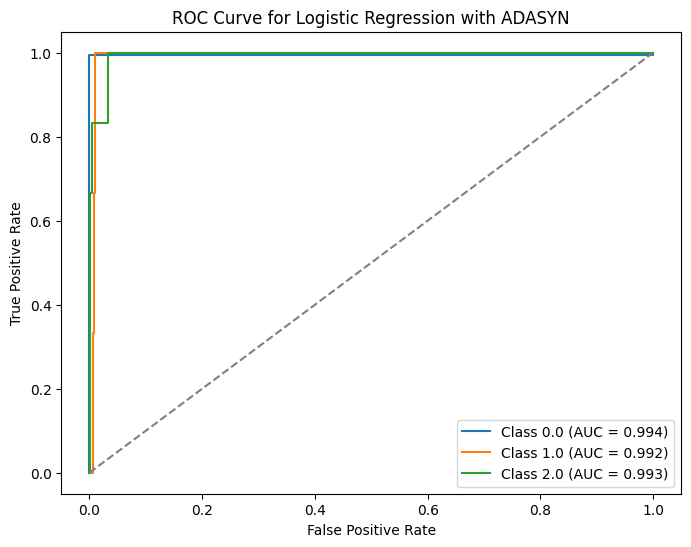

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import ADASYN

# Load Data
file_path = "hwc.xlsx"
sheet_name = "Sheet1"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Drop rare classes (less than 2 samples) from the target
class_counts = df['P_HABITABLE'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df['P_HABITABLE'].isin(valid_classes)]

# Define Features & Target
X = df.drop(columns=['P_HABITABLE'])  # Drop target variable from features
y = df['P_HABITABLE']  # Target variable

# Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Apply ADASYN for Resampling
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Standardize Features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Define Logistic Regression & Hyperparameter Grid
logreg = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
    'penalty': ['l2']
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Train the Best Model
best_logreg = grid_search.best_estimator_
best_logreg.fit(X_train_resampled, y_train_resampled)

# Predictions & Evaluation
y_pred = best_logreg.predict(X_test)
y_prob = best_logreg.predict_proba(X_test)

# Ensure ROC AUC Score works properly
if len(np.unique(y_test)) > 2:
    auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr')
else:
    auc_score = roc_auc_score(y_test, y_prob[:, 1])  # Binary classification

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", auc_score)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
if len(np.unique(y_test)) > 2:
    for i, label in enumerate(np.unique(y_test)):
        fpr, tpr, _ = roc_curve(y_test == label, y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {label} (AUC = {roc_auc_score(y_test == label, y_prob[:, i]):.3f})')
else:
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression with ADASYN")
plt.legend()
plt.show()

In [12]:
import joblib
joblib.dump(best_logreg, "logistic_regression_adasyn_model.pkl")

['logistic_regression_adasyn_model.pkl']